In [23]:
import cirq
import cirq_google
from cirq.contrib.svg import SVGCircuit
import sympy
import pandas
import datetime
import hashlib

In [7]:
# print the cirq 54-qubit Sycamore chip
working_device = cirq_google.Sycamore
print(working_device)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

In [8]:
# pick a qubit
my_qubit = cirq.GridQubit(2, 4)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


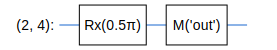

In [10]:
# build circuits that use your qubit

# Create a circuit with X, Ry(pi/2) and H.
my_circuit = cirq.Circuit(
    # Rotate the qubit pi/2 radians around the X axis.
    cirq.rx(3.141 / 2).on(my_qubit),
    # Measure the qubit.
    cirq.measure(my_qubit, key='out')
)
SVGCircuit(my_circuit)

In [11]:
# simulate
sim = cirq.Simulator()
samples = sim.sample(my_circuit, repetitions=10)
samples

,out
0,0
1,0
2,0
3,1
4,1
5,0
6,0
7,1
8,1
9,1


In [12]:
# get properties of circuit (density matrix, state vectors, etc.)
state_vector_before_measurement = sim.simulate(my_circuit[:-1])
sampled_state_vector_after_measurement = sim.simulate(my_circuit)

print(f'State before measurement:')
print(state_vector_before_measurement)
print(f'State after measurement:')
print(sampled_state_vector_after_measurement)

State before measurement:
measurements: (no measurements)
output vector: 0.707|0⟩ - 0.707j|1⟩
State after measurement:
measurements: out=1
output vector: -1j|1⟩


In [13]:
# noisy environment output (10% depolarization added)
noisy_sim = cirq.DensityMatrixSimulator(noise=cirq.depolarize(0.1))
noisy_post_measurement_state = noisy_sim.simulate(my_circuit)
noisy_pre_measurement_state = noisy_sim.simulate(my_circuit[:-1])

print('Noisy state after measurement:' + str(noisy_post_measurement_state))
print('Noisy state before measurement:' + str(noisy_pre_measurement_state))

Noisy state after measurement:measurements: out=0
final density matrix:
[[0.9333334 +0.j 0.        +0.j]
 [0.        +0.j 0.06666666+0.j]]
Noisy state before measurement:measurements: (no measurements)
final density matrix:
[[0.50012845+0.j         0.        +0.43333334j]
 [0.        -0.43333334j 0.49987155+0.j        ]]


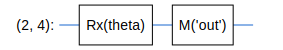

In [15]:
# create a parameterized circuit that rotates by angle theta
theta = sympy.Symbol('theta')

parameterized_circuit = cirq.Circuit(
    cirq.rx(theta).on(my_qubit),
    cirq.measure(my_qubit, key='out')
)
SVGCircuit(parameterized_circuit)

In [16]:
# specify theta value for simulation
samples_at_theta_equals_2 = sim.sample(
    parameterized_circuit, 
    params={theta: 2}, 
    repetitions=10)
samples_at_theta_equals_2

,theta,out
0,2,1
1,2,1
2,2,1
3,2,0
4,2,0
5,2,1
6,2,0
7,2,0
8,2,1
9,2,1


In [17]:
# multiple values for theta
samples_at_multiple_theta = sim.sample(
    parameterized_circuit, 
    params=[{theta: 0.5}, {theta: 3.141}], 
    repetitions=10)
samples_at_multiple_theta

,theta,out
0,0.500,0
1,0.500,0
2,0.500,0
3,0.500,0
4,0.500,0
5,0.500,0
6,0.500,0
7,0.500,0
8,0.500,0
9,0.500,0


In [18]:
# cirq shorthand for multiple values sweep
samples_at_swept_theta = sim.sample(
    parameterized_circuit, 
    params=cirq.Linspace(theta, start=0, stop=3.14159, length=5), 
    repetitions=5)
samples_at_swept_theta

,theta,out
0,0.000000,0
1,0.000000,0
2,0.000000,0
3,0.000000,0
4,0.000000,0
0,0.785397,0
1,0.785397,0
2,0.785397,0
3,0.785397,1
4,0.785397,0


<AxesSubplot:xlabel='theta'>

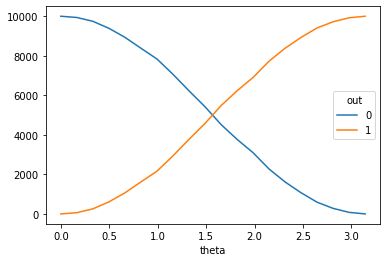

In [20]:
# use pandas for analysis
big_results = sim.sample(
    parameterized_circuit, 
    params=cirq.Linspace(theta, start=0, stop=3.14159, length=20), 
    repetitions=10_000)

# big_results is too big to look at. Plot cross tabulated data instead.
pandas.crosstab(big_results.theta, big_results.out).plot()

/home/rimuru/.local/lib/python3.8/site-packages/cirq/experiments/qubit_characterizations.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='Rabi Angle (Radian)', ylabel='Excited State Probability'>

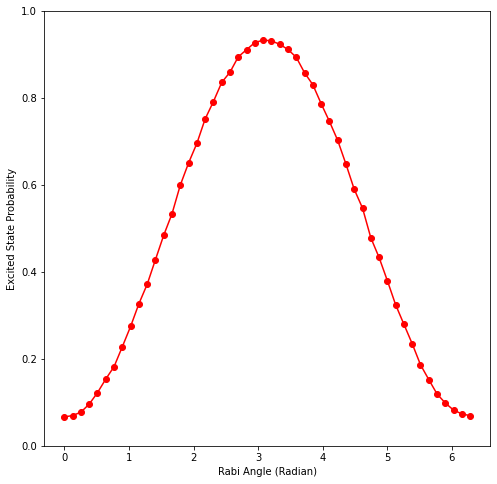

In [22]:
# cirq built-in rabi oscillation
result = cirq.experiments.rabi_oscillations(
    sampler=noisy_sim,
    qubit=my_qubit,
    num_points=50,
    repetitions=10000)
result.plot()

In [24]:
# find the qubit with the lowest noise
class SecretNoiseModel(cirq.NoiseModel):
    def noisy_operation(self, op):
        # Hey! No peeking!
        q = op.qubits[0]
        v = hashlib.sha256(str(q).encode()).digest()[0] / 256
        yield cirq.depolarize(v).on(q)
        yield op

secret_noise_sampler = cirq.DensityMatrixSimulator(noise=SecretNoiseModel())

qubit cirq.GridQubit(1, 5)


/home/rimuru/.local/lib/python3.8/site-packages/cirq/experiments/qubit_characterizations.py:99: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='Rabi Angle (Radian)', ylabel='Excited State Probability'>

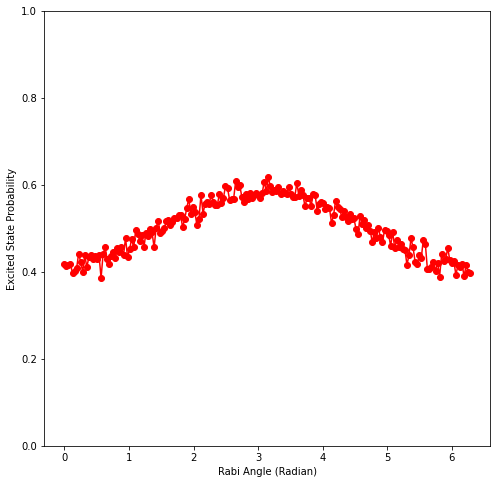

In [25]:
q = cirq_google.Sycamore.qubits[3]
print('qubit', repr(q))
cirq.experiments.rabi_oscillations(
    sampler=secret_noise_sampler,
    qubit=q
).plot()